## Legal and regulatory maps

In [6]:
# IMPORTS
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
#import contextily as cx
import requests
import calendar
from importlib import reload

from datetime import datetime, timedelta
from shapely.geometry import Point
from io import StringIO
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Patch

from geopandas import GeoDataFrame

# Custom modules are imported in multiple locations to faciliate easy reloading when edits are made to their respective files
import Src.classes as cl
import Src.func_ko as fn
reload(cl)
reload(fn)

<module 'Src.func_ko' from 'C:\\Users\\kondr\\Documents\\GitHub\\HighMagFlows_EPA_Project\\Src\\func_ko.py'>

### Plot selected aquifers and streams

In [3]:
# Aquifers to plot and dataset to use
lower48 = gpd.read_file('ShapeFiles/Lower48/lower48.shp')
aq_shape = gpd.read_file('ShapeFiles/Aquifers/_Master_Aquifer/master_aquifer.shp')
aq_usgs = gpd.read_file('ShapeFiles/Aquifers_USGS_25/Aquifers_USGS_25.shp')
streams = gpd.read_file('ShapeFiles/Streams_US/us_streams.shp')
counties_us = gpd.read_file('ShapeFiles/Counties_US/cb_2018_us_county_20m.shp')

aquifers = cl.ALL_AQUIFERS
range = 30
quantile = 90

# Metric to be plotted where metrics are column names from the dataset
metric = 'inter_annual%'
# True if you want to show HUC4 boundaries (significantly increases runtime)
show_huc4 = False
show_gauges = False
# True if you want to save image. Overwrite true if you want to overwrite existing image of same name
save_img = True
overwrite = True
# True if you want a context basemap (adds runtime)
basemap = False

try:
    dataset = f'Prelim_Data/National_Metrics_{range}_{quantile}.xlsx'
    df = pd.read_excel(dataset, sheet_name='site_metrics', dtype=fn.DATASET_DTYPES)
    df, _ = fn.filter_by_valid(df)
except Exception as e:
    df = None
    print(e)

module 'Src.func_ko' has no attribute 'DATASET_DTYPES'


In [63]:
# Calculate percentage of aquifer in each state
from geopandas.tools import sjoin

lower48 = lower48.to_crs(epsg=4269)
aq_gdf = aq_gdf.to_crs(epsg=4269)

lower48['g1'] = lower48.geometry #The geometry column is lost in the sjoin
aq_shape['g2'] = aq_shape.geometry 

#Spatial join the dataframe to then only intersect the intersecting geometries
#inter = lower48.sjoin(aq_shape)
inter = gpd.sjoin(lower48, aq_shape)
inter.columns
#Index(['id1', 'geometry', 'original_area', 'index_right', 'id2'], dtype='object')

def overlap_pct(frame):
    """A function to calculate overlap percentage"""
    interpct = 100*frame.g1.intersection(frame.g2).area/frame.g1.area
    return interpct

inter['pct'] = inter.apply(overlap_pct, axis=1)
#inter.columns
#Index(['id1', 'geometry', 'g1', 'index_right', 'id2', 'g2', 'pct'], dtype='object')

#Merge the intersect result and the input dataframe
result = pd.merge(inter, lower48, on='STUSPS',how='outer').set_geometry('geometry_y').rename_geometry('geometry')

result = result[['STUSPS','aq_name','pct','geometry']]
#result[0:30]

In [29]:
from geopandas import GeoDataFrame

# Assuming gdf is your GeoDataFrame
# lower48_df = lower48.drop(columns='geometry')  # Remove geometry column
# lower48_df.to_excel('lower48_df.xlsx', index=False)  # Export DataFrame to Excel

In [7]:
lower48_df_edit = pd.read_excel('lower48_df_edit.xlsx')
lower48_wr = GeoDataFrame(lower48_df_edit, geometry=lower48.geometry)

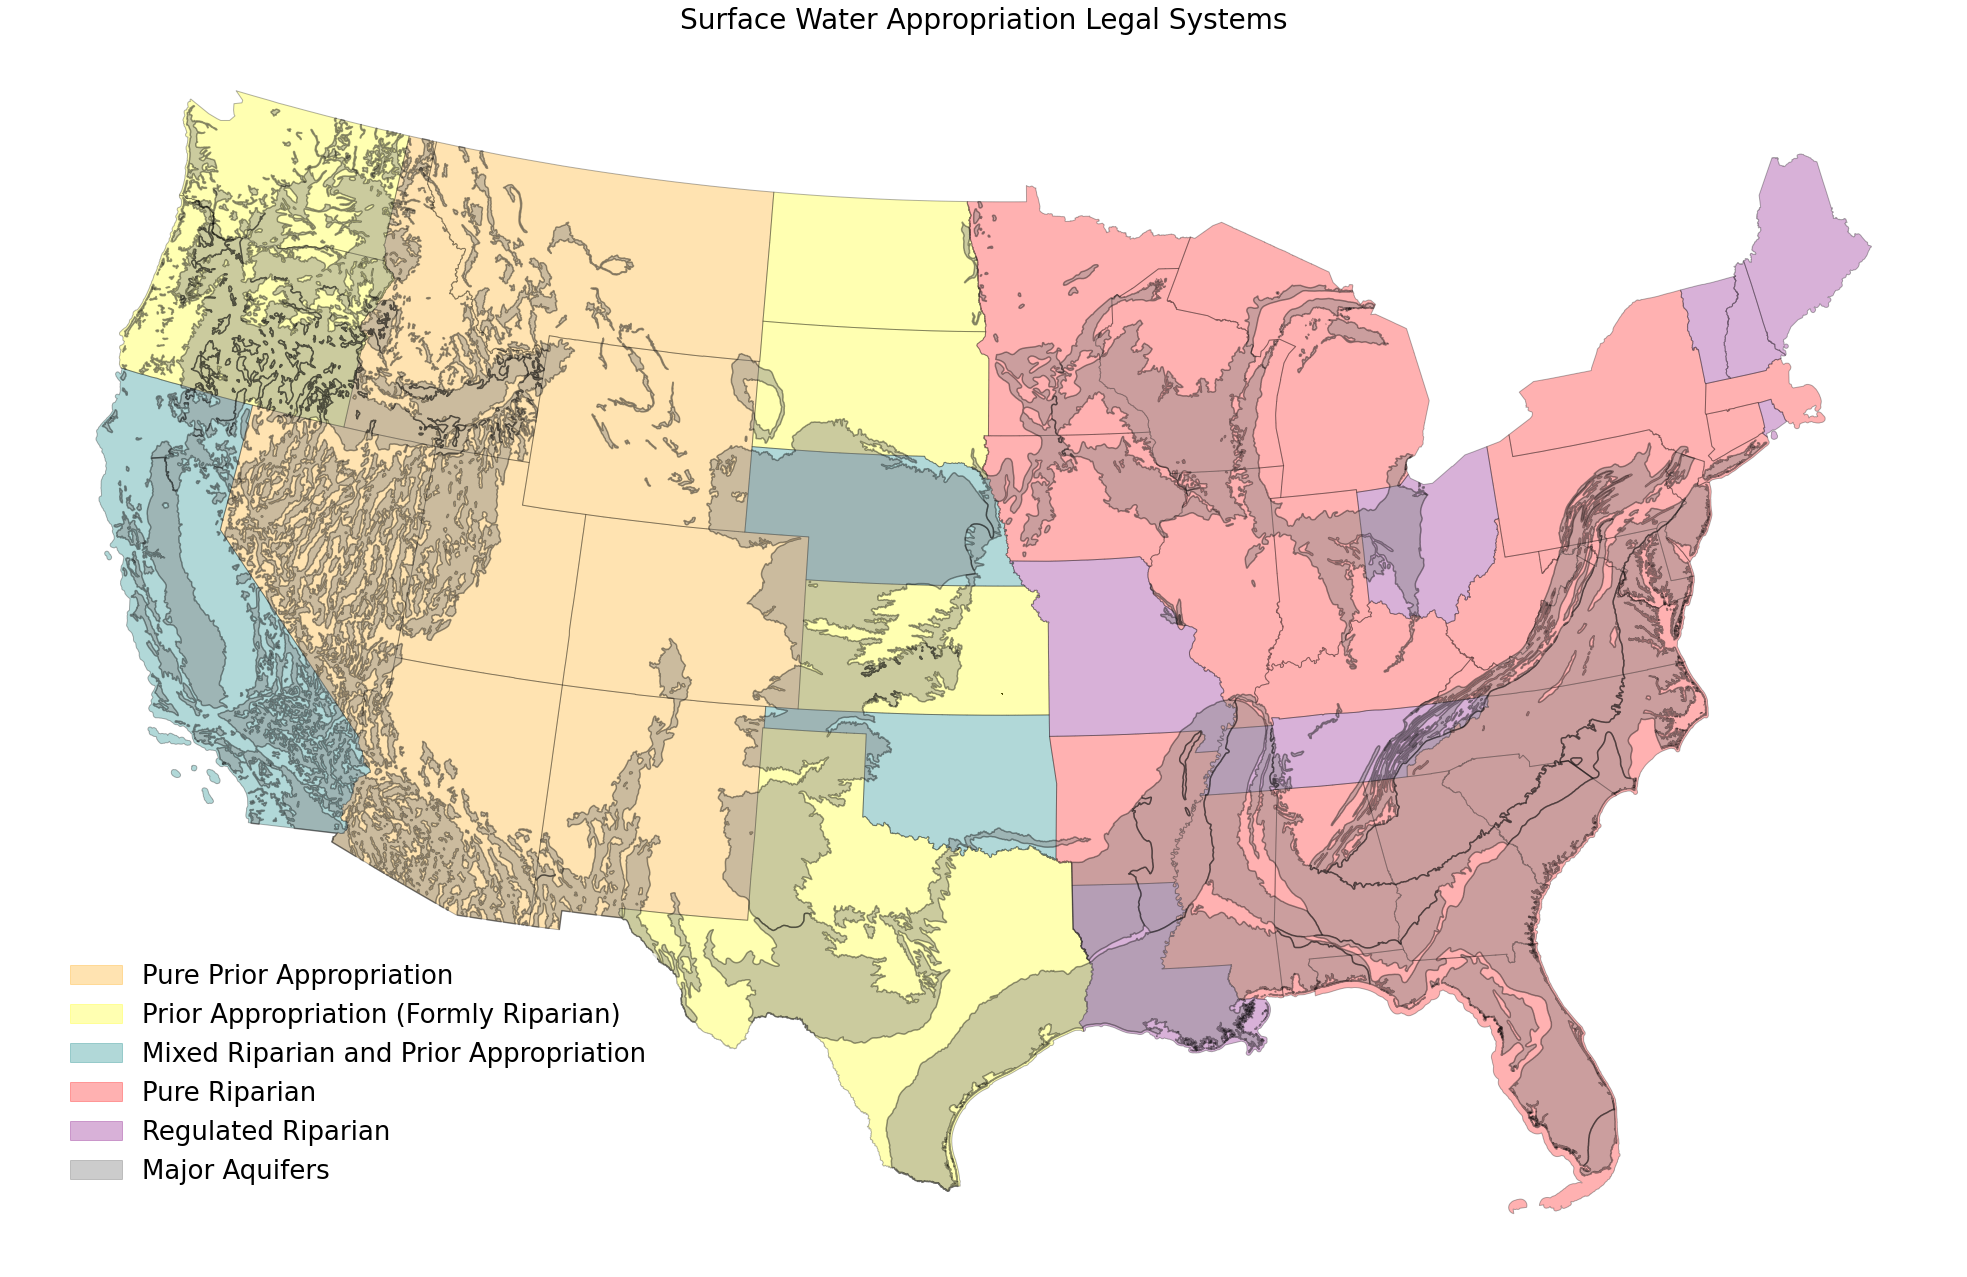

In [8]:
lower48_wr = lower48_wr.to_crs('ESRI:102003')
aq_usgs = aq_usgs.to_crs('ESRI:102003')

fig, ax = plt.subplots(figsize=(35, 35))
plt.title('Surface Water Appropriation Legal Systems', fontsize=28)

lower48.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1.0)  

lower48_wr[lower48_wr['sw_right'] == 'app'].plot(facecolor='orange', edgecolor='black', linewidth=1.0, alpha=0.3, ax=plt.gca())
lower48_wr[lower48_wr['sw_right'] == 'app_new'].plot(facecolor='yellow', edgecolor='black', linewidth=1.0, alpha=0.3, ax=plt.gca())
lower48_wr[lower48_wr['sw_right'] == 'mixed'].plot(facecolor='teal', edgecolor='black', linewidth=1.0, alpha=0.3, ax=plt.gca())
lower48_wr[lower48_wr['sw_right'] == 'reg_rip'].plot(facecolor='red', edgecolor='black', linewidth=1.0, alpha=0.3, ax=plt.gca())
lower48_wr[lower48_wr['sw_right'] == 'pure_rip'].plot(facecolor='purple', edgecolor='black', linewidth=1.0, alpha=0.3, ax=plt.gca())

aq_usgs.plot(ax=ax, edgecolor='black', facecolor='grey', linewidth=1.5, alpha=0.4)

# Plot legend
handles = []  # Store handles for legend
labels = []   # Store labels for legend
handles.extend([Patch(color='orange', alpha=0.3), 
                Patch(color='yellow', alpha=0.3),
                Patch(color='teal', alpha=0.3),
                Patch(color='red', alpha=0.3),
                Patch(color='purple', alpha=0.3),
                Patch(color='grey', alpha=0.4)])  # Add the handle for legend
labels.extend(['Pure Prior Appropriation', 'Prior Appropriation (Formly Riparian)', 'Mixed Riparian and Prior Appropriation',
                'Pure Riparian', 'Regulated Riparian', 'Major Aquifers'])  # Add the label for legend
#legend = ax.get_legend()
legend = ax.legend(handles, labels, loc='lower left', bbox_to_anchor=(0.02, 0.05), fontsize=26)
frame = legend.get_frame()  # Get the legend frame
frame.set_linewidth(0)

ax.axis("off")

img_path = f'Saved_Visuals/sw_rights_map.png'
fn.save_plot_as_image(img_path, overwrite)

plt.show()

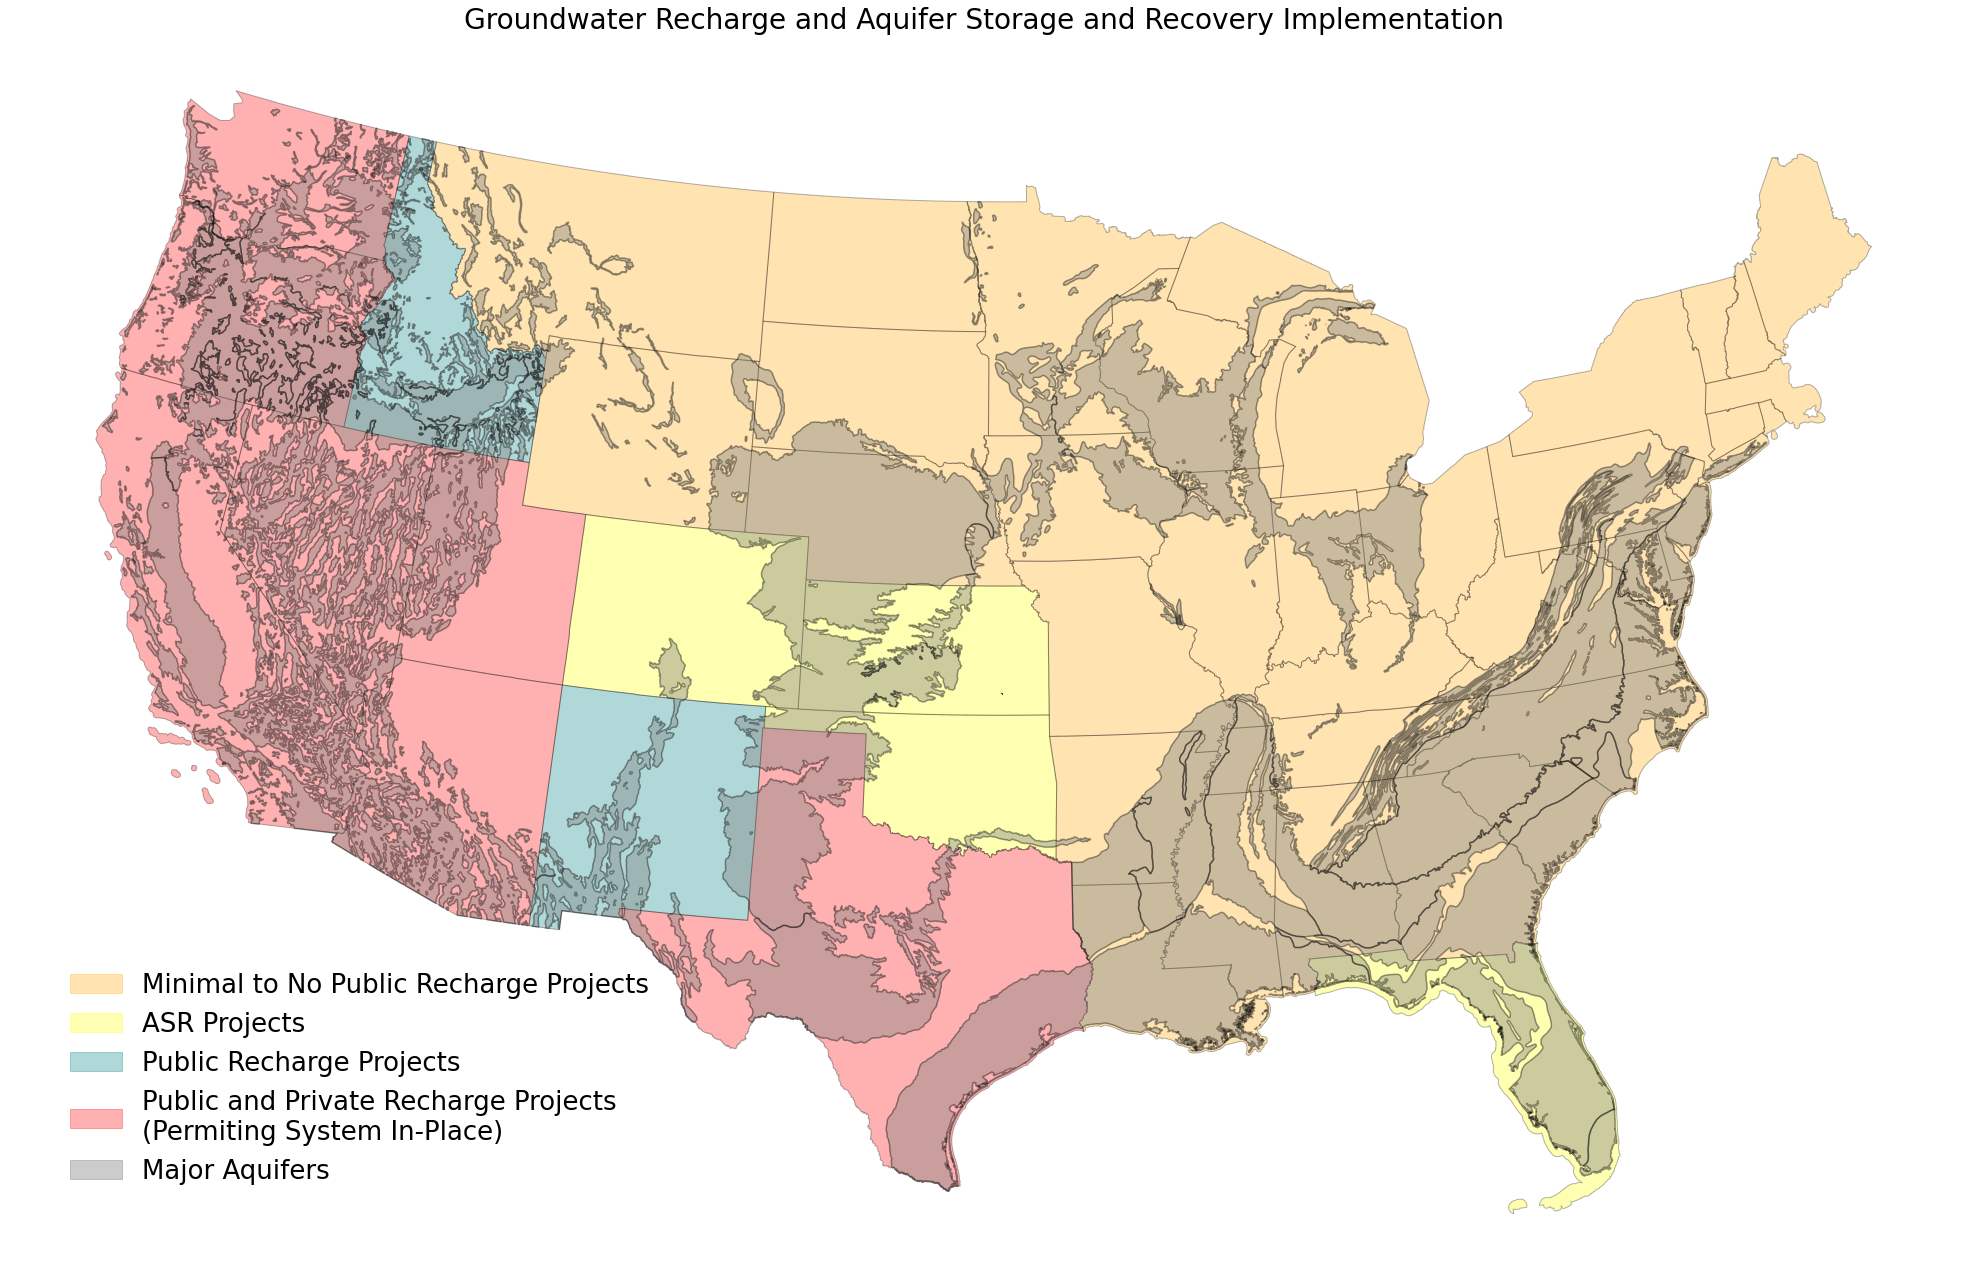

In [9]:
fig, ax = plt.subplots(figsize=(35, 35))
plt.title('Groundwater Recharge and Aquifer Storage and Recovery Implementation', fontsize=28)

lower48.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1.0)  

lower48_wr[lower48_wr['recharge_type'] == 'none'].plot(facecolor='orange', edgecolor='black', linewidth=1.0, alpha=0.3, ax=plt.gca())
lower48_wr[lower48_wr['recharge_type'] == 'asr'].plot(facecolor='yellow', edgecolor='black', linewidth=1.0, alpha=0.3, ax=plt.gca())
lower48_wr[lower48_wr['recharge_type'] == 'both_gov'].plot(facecolor='teal', edgecolor='black', linewidth=1.0, alpha=0.3, ax=plt.gca())
lower48_wr[lower48_wr['recharge_type'] == 'both_permit'].plot(facecolor='red', edgecolor='black', linewidth=1.0, alpha=0.3, ax=plt.gca())

aq_usgs.plot(ax=ax, edgecolor='black', facecolor='grey', linewidth=1.5, alpha=0.4)

# Plot legend
handles = []  # Store handles for legend
labels = []   # Store labels for legend
handles.extend([Patch(color='orange', alpha=0.3), 
                Patch(color='yellow', alpha=0.3),
                Patch(color='teal', alpha=0.3),
                Patch(color='red', alpha=0.3),
                Patch(color='grey', alpha=0.4)])  # Add the handle for legend
labels.extend(['Minimal to No Public Recharge Projects', 'ASR Projects', 'Public Recharge Projects', 'Public and Private Recharge Projects \n(Permiting System In-Place)', 'Major Aquifers'])  # Add the label for legend
legend = ax.legend(handles, labels, loc='lower left', bbox_to_anchor=(0.02, 0.05), fontsize=26)
frame = legend.get_frame()  # Get the legend frame
frame.set_linewidth(0)

ax.axis("off")

img_path = f'Saved_Visuals/recharge_implementation_map.png'
fn.save_plot_as_image(img_path, overwrite)

plt.show()